In [1]:
from typing import Union
import numpy as np
import pandas as pd
import numpy.typing as npt
from typing import Tuple
from tqdm import tqdm
from matplotlib import pyplot as plt
from simulations.stochastic_models import StochasticModels

from utility.math_equations import (
    compute_currrent_step_log_price,
    compute_next_step_log_vol,
)

from filters.kalman_filter import LinearKalmanFilterND
from filters.unscented_kalman_filter import UnscentedKalmanFilter

In [2]:
# Seed for reproducibility
np.random.seed(42)


t, prices = StochasticModels.simulate_random_walk_process(5, 100)

df = pd.DataFrame({"t": t, "prices": prices})
df["returns"] = df.prices.pct_change().fillna(0)
df["vol"] = df.returns.rolling(30).std()
df = df.dropna()
df

,t,prices,returns,vol
29,0.115079,71.777966,-0.019915,0.045124
30,0.119048,68.769433,-0.041914,0.045426
31,0.123016,78.030823,0.134673,0.052758
32,0.126984,77.963337,-0.000865,0.052253
33,0.130952,72.674783,-0.067834,0.051011
...,...,...,...,...
1256,4.984127,341.856934,0.025076,0.017462
1257,4.988095,343.952029,0.006129,0.017466
1258,4.992063,340.426970,-0.010249,0.017426
1259,4.996032,340.148124,-0.000819,0.016323


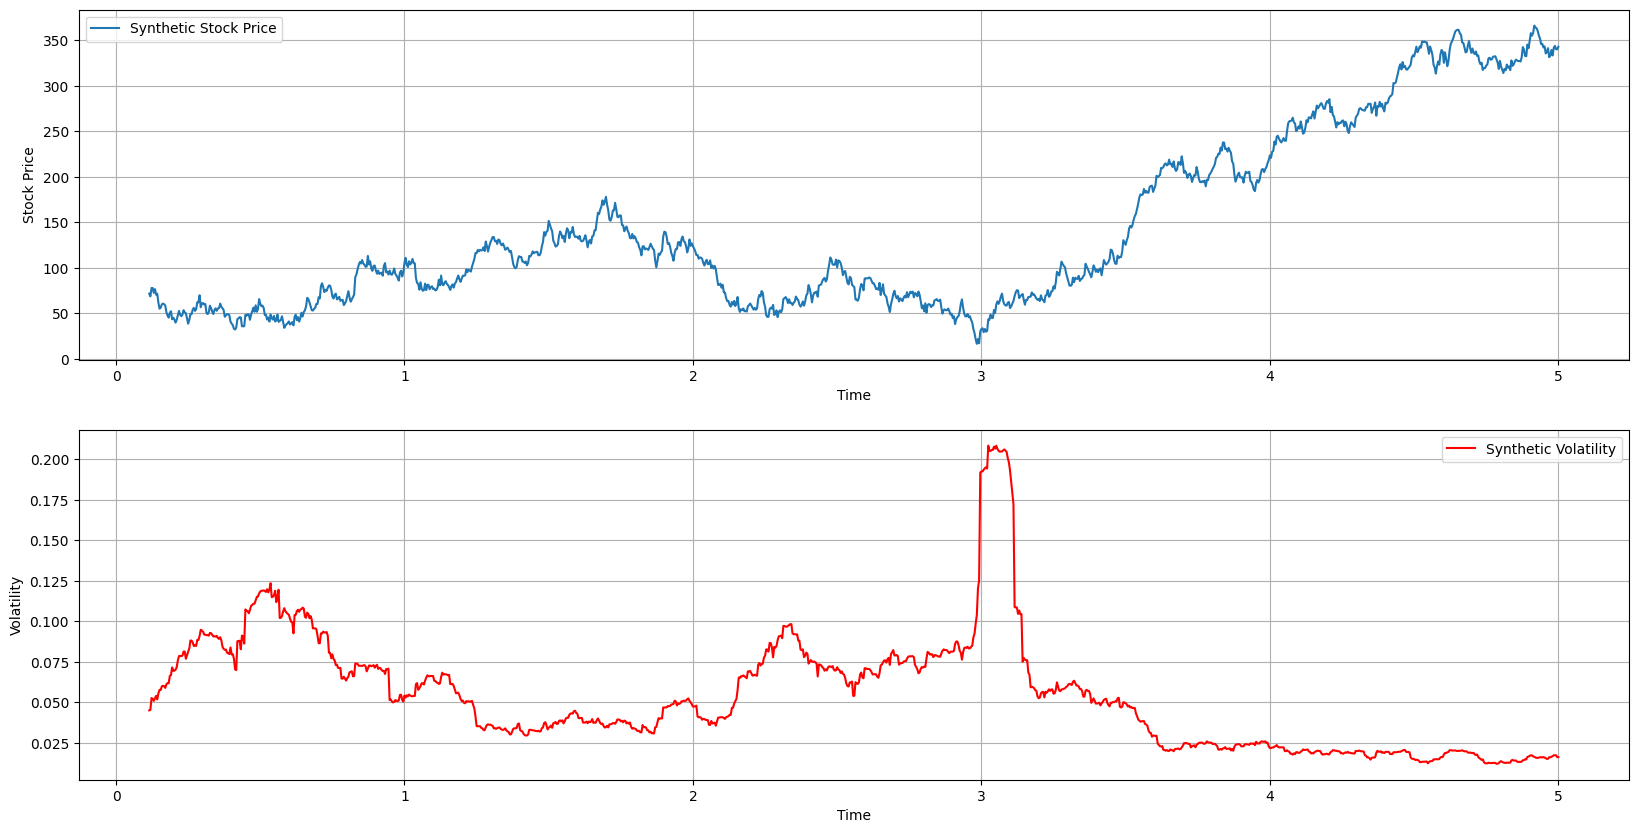

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df.t, df.prices, label="Synthetic Stock Price")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(df.t, df.vol, color="red", label="Synthetic Volatility")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()

In [4]:
LEARNABLE_PARAMS = [0.2, 0.02, 0.03, -0.3, 0.07, 0.5]

In [5]:
kf_matriciel = LinearKalmanFilterND(
    F=np.array([[1.0]]),
    H=np.array([[1.0]]),
    Q=np.array([[0.5]]),
    R=np.array([[0.5]]),
)

x_hat, P_var, y_hat, V_var = kf_matriciel.fit_predict(
    df.prices.to_numpy().reshape(-1, 1), verbose=False
)

Kalman Filter Progress: 100%|██████████| 1231/1231 [00:00<00:00, 8077.15it/s]


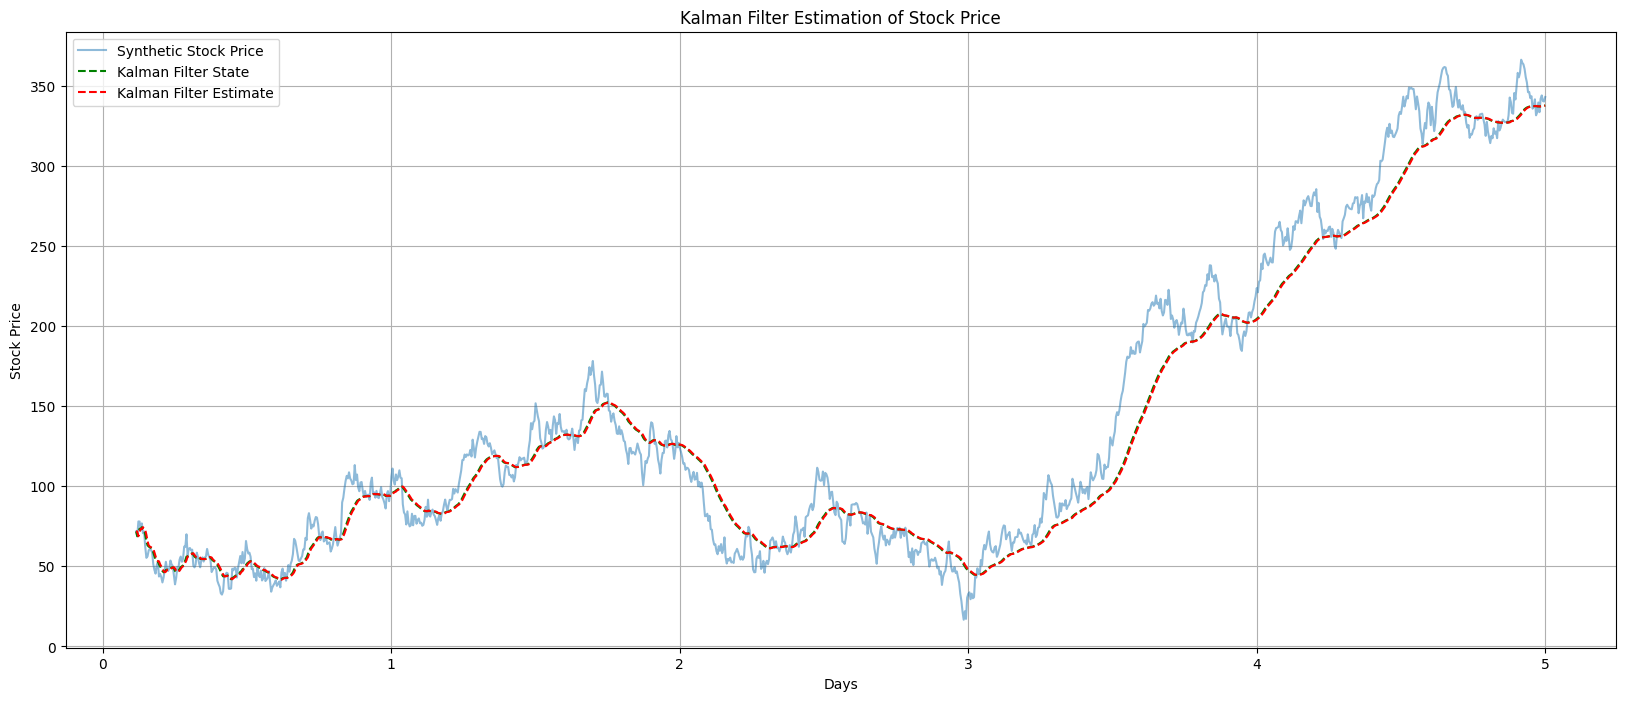

In [6]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(df.t, df.prices, label="Synthetic Stock Price", alpha=0.5)
plt.plot(df.t, x_hat, label="Kalman Filter State", linestyle="--", color="green")
plt.plot(df.t, y_hat, label="Kalman Filter Estimate", linestyle="--", color="red")
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
kf_matriciel = LinearKalmanFilterND(
    F=np.array([[1.0, 0.0], [0.0, 1.0]]),
    H=np.array([[1.0, 0.0], [0.0, 1.0]]),
    Q=np.array([[1.0, 0.0], [0.0, 1.0]]),
    R=np.array([[1.0, 0.0], [0.0, 1.0]]),
)

x_hat, P_var, y_hat, V_var = kf_matriciel.fit_predict(
    df[["prices", "vol"]].to_numpy(), verbose=False
)

Kalman Filter Progress: 100%|██████████| 1231/1231 [00:00<00:00, 10136.68it/s]


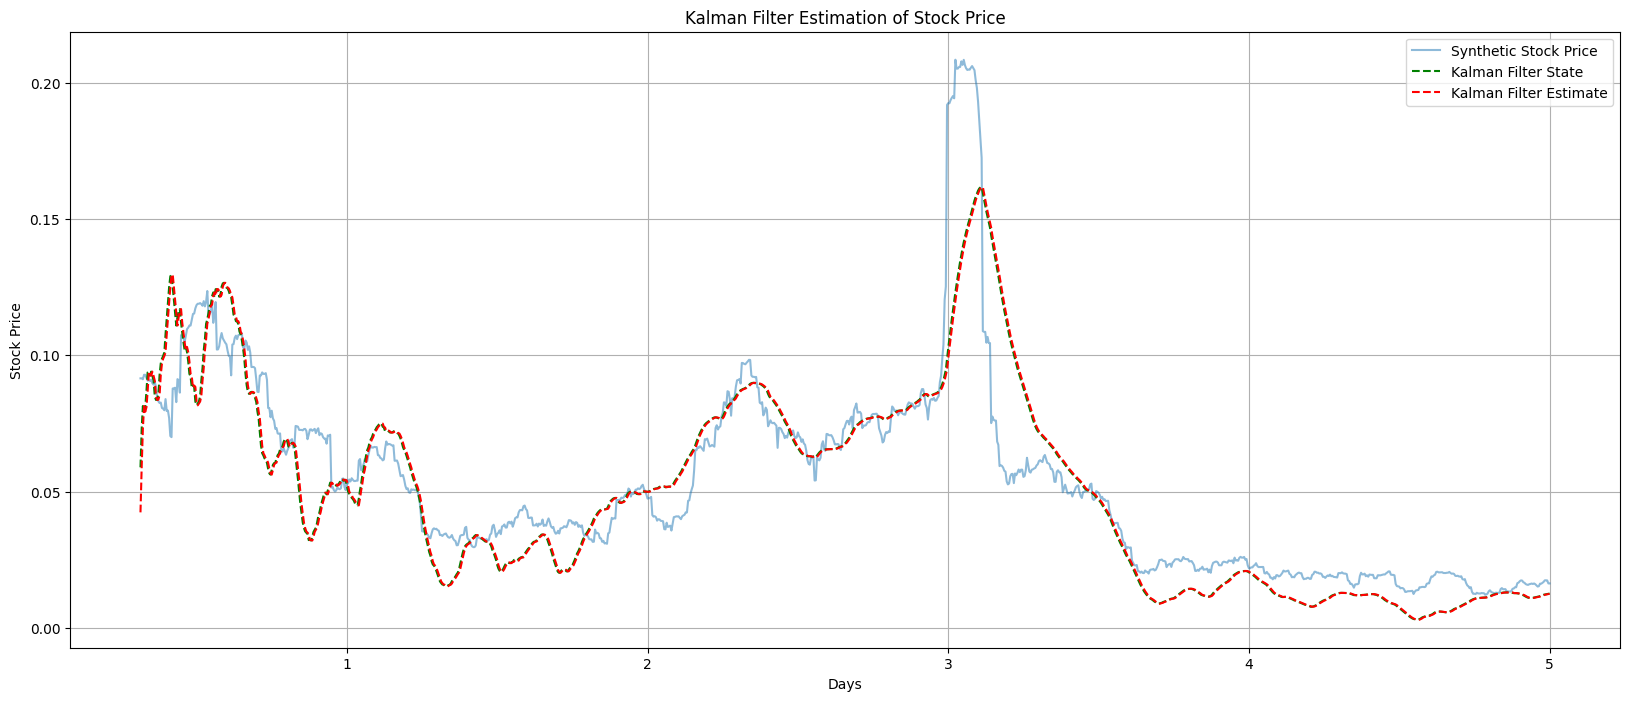

In [8]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(df.t[50:], df.vol[50:], label="Synthetic Stock Price", alpha=0.5)
plt.plot(
    df.t[50:],
    x_hat[50:, -1],
    label="Kalman Filter State",
    linestyle="--",
    color="green",
)
plt.plot(
    df.t[50:],
    y_hat[50:, -1],
    label="Kalman Filter Estimate",
    linestyle="--",
    color="red",
)
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Let's UKF


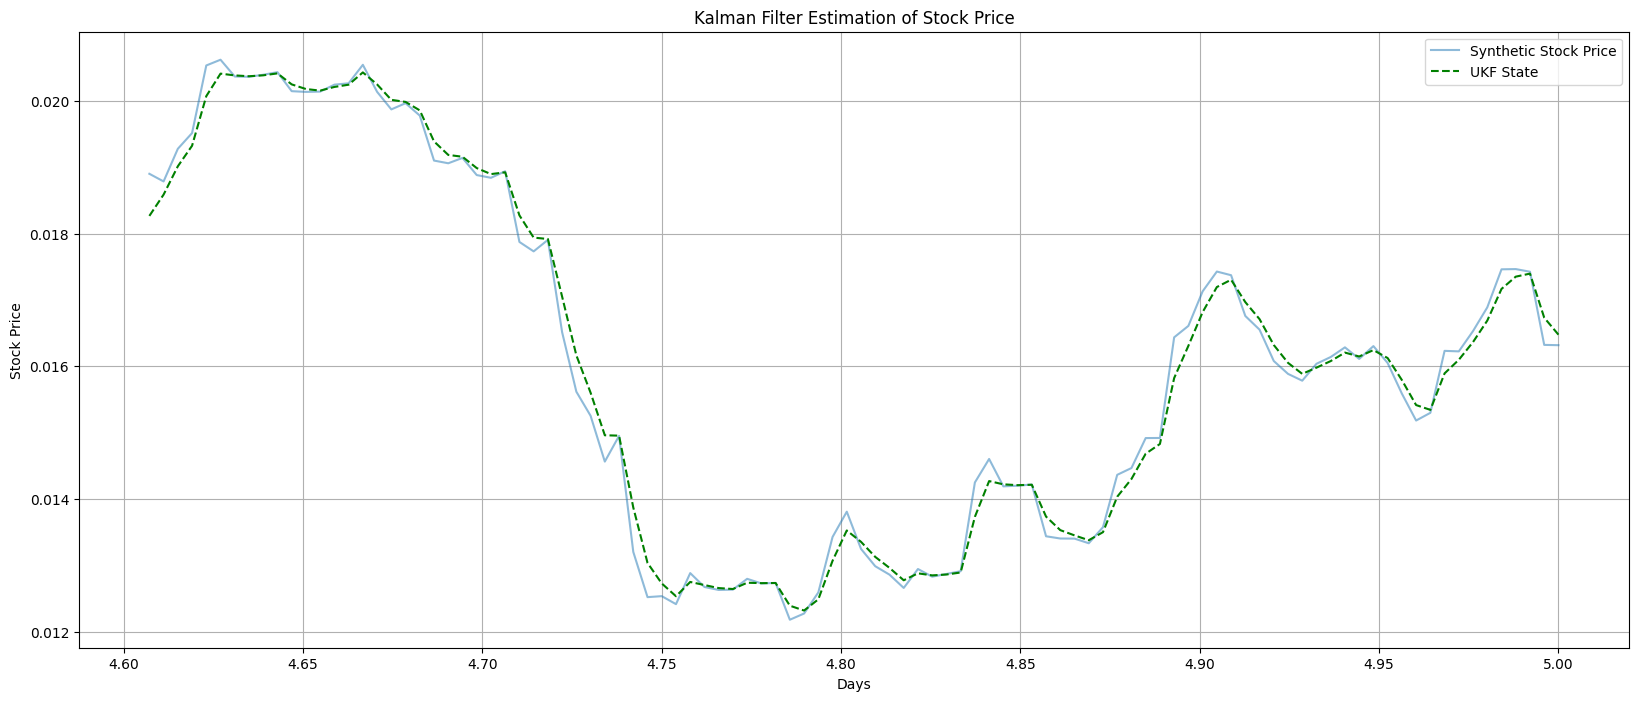

In [9]:
Z = df[["prices", "vol"]].to_numpy()

ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[5, 0.0], [0.0, 10]]),
    R=np.array([[5, 0.0], [0.0, 10]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _ = ukf.fit_predict(f, h, Z)


# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(df.t[-100:], df.vol[-100:], label="Synthetic Stock Price", alpha=0.5)
plt.plot(
    df.t[-100:], X_hat[-100:, -1], label="UKF State", linestyle="--", color="green"
)
# plt.plot(df.t[50:], y_hat[50:,-1], label="Kalman Filter Estimate", linestyle="--", color="red")
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()